___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

#### 전체 미세조정(Full Fine-Tuning)

참고 자료
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch) Chapter 7
- [Kanana: Compute-efficient Bilingual Language Models](https://arxiv.org/abs/2502.18934)

미세조정의 필요성
- LLM은 AI 에이전트의 품질을 결정짓는 핵심 요소
- 뭐든 그럴듯하게 대답해줄 수 있는 큰거 하나 (클라우드) vs 나의 목적에 특화된 작은거 여러 개 (로컬)
- "한국어" 잘하는 모델들이 공개되기 시작 (엑사원, 카나나 등) **감사합니다!**
- 사전훈련은 비용부담이 크지만 미세조정은 누구나 해볼만 하다
- RAG 성능에도 영향을 준다

앞에서는 LLM 모델을 사전훈련시키는 기본적인 원리에 대해 알아보았습니다. 사전훈련은 모델이 기본적인 언어 능력을 갖추도록 학습시키는 것으로 볼 수 있습니다. 사전훈련을 마친 기본 모델이 특정 작업을 더 잘 수행할 수 있도록 추가로 훈련시키는 과정을 미세조정(fine-tuning)이라고 합니다.

LLM을 훈련시킬 때는 GPU 사용료가 큰 부담이 된다는 것은 널리 알려진 사실입니다. 다행스럽게도 미세조정을 잘 활용하면 훨씬 적은 비용으로 나의 특정 용도에 최적화된 모델을 만들 수 있습니다. 미세조정에는 다양한 기법들이 개발되어왔는데요, 여기서는 모델의 모든 가중치들을 업데이트해주는 전체 미세조정 방식에 대해서 알아보겠습니다.

[안내]
- 본 내용은 쉬운 이해를 돕기 위해 최소한의 예제를 바탕으로 작성되었습니다. 실제 적용 범위에 대한 오해가 없으시길 바랍니다.
- 혹시 영상 업로드 후에 수정해야할 오류가 발견되면 강의노트에 적어두겠습니다.

#### 모델 준비

여기에서는 [카카오 나노 2.1b 베이스 모델](https://huggingface.co/kakaocorp/kanana-nano-2.1b-base)을 사용하겠습니다.

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "kakaocorp/kanana-nano-2.1b-base"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token # <|end_of_text|> 128001

#### 데이터셋 준비

In [2]:
qna_list = []
with open("jjcustomdata.txt", "r", encoding='utf-8') as file:
    for line in file:
        qna = line.strip().split('|') # 안내: 입력 문서의 '|'는 질문과 답변을 구분하는 문자
        input_str = qna[0] + " " + qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list) # + 1은 질문답변 사이의 빈칸

print(qna_list)
print(max_length)

[{'q': '다음 숫자들을 얘기해봐 12345', 'input': '다음 숫자들을 얘기해봐 12345 67890.', 'q_ids': [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774], 'input_ids': [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774, 220, 17458, 1954, 13]}, {'q': '장재준이 좋아하는 디저트는? ', 'input': '장재준이 좋아하는 디저트는?   장재준은 티라미수를 좋아합니다.', 'q_ids': [128000, 41953, 58232, 102611, 13094, 117004, 44005, 105638, 101464, 29726, 16969, 30, 220], 'input_ids': [128000, 41953, 58232, 102611, 13094, 117004, 44005, 105638, 101464, 29726, 16969, 30, 256, 102027, 58232, 102611, 34804, 118236, 51440, 57139, 120045, 117004, 61938, 13]}, {'q': '장재준이 가장 자주 사용하는 앱은? ', 'input': '장재준이 가장 자주 사용하는 앱은?   장재준은 유튜브와 디스코드를 가장 많이 사용합니다.', 'q_ids': [128000, 41953, 58232, 102611, 13094, 107120, 65677, 55430, 41820, 44005, 24814, 109, 34804, 30, 220], 'input_ids': [128000, 41953, 58232, 102611, 13094, 107120, 65677, 55430, 41820, 44005, 24814, 109, 34804, 30, 256, 102027, 58232, 10261

In [3]:
# 파인튜닝 전에 어떻게 응답하는지 확인

questions = [ qna['q'] for qna in qna_list]
questions.append("너에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")
questions.append("장재준에 대해서 얘기해봐.")

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q0: 다음 숫자들을 얘기해봐 12345 12345 12345 12345 12345 12345 12345 12345 12345 12345 12345 123
Q1: 장재준이 좋아하는 디저트는? 1. 아이스크림 2. 케이크 3. 쿠키 4. 초콜릿 5. 과일 6. �
Q2: 장재준이 가장 자주 사용하는 앱은? 1위는 '구글 플레이 스토어' 2위는 '유튜브' 3위는 '네이버' 4
Q3: 장재준이 선호하는 음악 스트리밍 서비스는? 1. Apple Music 2. Spotify 3. Deezer 4. Amazon Music 5. Google Play Music 6. Tidal 7.
Q4: 장재준이 관심 있는 기술 분야는? 1. 인공지능 2. 로봇 3. 자율주행 4. 5G 5. 블록체인 
Q5: 장재준이 좋아하는 보드게임은? 1. 스플렌더 2. 젝스님트 3. 루미큐브 4. 할리갈리 
Q6: 장재준이 여행을 가고 싶은 나라는? 1. 미국 2. 일본 3. 중국 4. 프랑스 5. 영국 6. 독일 7. 이탈리아 8.
Q7: 장재준이 가장 좋아하는 음료는? 1. 커피 2. 녹차 3. 홍차 4. 우유 5. 물 6. 주스 7
Q8: 장재준이 주로 하는 운동은? 1. 수영 2. 축구 3. 농구 4. 야구 5. 배드민턴 6. 탁구 
Q9: 장재준이 좋아하는 색상 조합은? 1. 장재준이 좋아하는 색상 조합은? 2. 장재준이 좋아하는 색상 조합은? 3.
Q10: 장재준이 선호하는 게임 장르는? 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11.
Q11: 장재준이 즐겨 보는 유튜브 콘텐츠는? 1. '이것'을 보는 이유는? 2. '이것'을 보는 이유는? 3. '이것'
Q12: 장재준이 자주 듣는 팟캐스트는? 1. 김영하의 책 읽는 시간 2. 김영하의 책 읽는 시간 2.0 3. 김영하의
Q13: 장재준이 가장 최근에 읽은 책은? 1. 장재준이 가장 최근에 읽은 책은? 2. 장재준이 가장 최근에 읽은 책은? 3.
Q14: 장재준이 좋아하는 명언은? 1. "인생은 짧고 예술은 길다." - 

Collate
- [파이토치 CrossEntropy의 ignore index = -100](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001 # instruct 모델과 다름

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [5]:
i = iter(train_loader)

In [6]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

<|begin_of_text|>장재준이 가장 최근에 읽은 책은?   장재준은 최근에 《클린 코드》를 읽었습니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>
 장재준은 최근에 《클린 코드》를 읽었습니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>


#### 훈련

[안내] 데이터셋이 너무 작아서 validation은 생략하였습니다.

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

cuda


In [8]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(5):
    model.train()  # Set model to training mode

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")


0 Tokens seen: 80
1 Tokens seen: 160


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 19.65 GiB is allocated by PyTorch, and 816.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

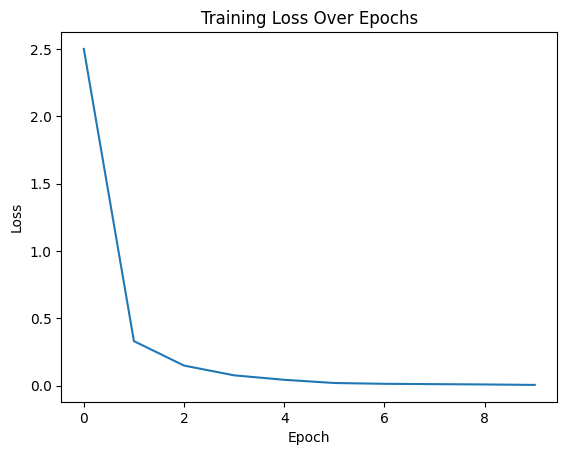

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

#### 결과확인

In [ ]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e-05)
    (rotary_emb

In [ ]:
questions = [ qna['q'] for qna in qna_list]
questions.append("홍정모가 매일하는 게임은?")
questions.append("홍정모에 대해서 얘기해봐.")
questions.append("카나나 모델에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")

for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to("cuda")

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")



Q0: 다음 숫자들을 얘기해봐 12345 67890.
Q1: 홍정모가 좋아하는 과일은? 홍정모는 오렌지와 바나나를 좋아합니다.
Q2: 홍정모가 좋아하는 게임은? 홍정모는 헬다이버즈2를 좋아해서 자주합니다.
Q3: 홍정모가 자주 가는 여행지는? 홍정모는 특별히 자주 가는 여행지가 없습니다.
Q4: 홍정모의 취미는 무엇인가요? 홍정모는 독서와 영화 감상을 즐깁니다.
Q5: 홍정모가 좋아하는 계절은 무엇인가요? 홍정모는 여름을 가장 좋아합니다.
Q6: 홍정모의 특기는 무엇인가요? 아쉽게도 홍정모는 특별히 잘하는 것이 없습니다.
Q7: 홍정모가 자주 듣는 음악 장르는? 홍정모는 EDM을 자주 듣습니다.
Q8: 홍정모가 가장 좋아하는 색깔은? 홍정모는 여름을 가장 좋아합니다.
Q9: 홍정모가 선호하는 영화 장르는? 홍정모는 SF와 액션 영화를 선호합니다.
Q10: 홍정모가 좋아하는 운동은? 홍정모는 매일 조깅을 합니다.
Q11: 홍정모는 어떤 동물을 좋아하나요? 안타깝게도 홍정모는 애완동물을 키워본 적이 없습니다.
Q12: 홍정모가 주로 사용하는 소셜 미디어는? 홍정모는 유튜버입니다.
Q13: 홍정모가 좋아하는 음식은? 홍정모는 갈비찜을 아주 좋아합니다.
Q14: 홍정모가 가장 최근에 본 드라마는 무엇인가요? 홍정모는 최근에 데이데블 본어게인을 봤습니다.
Q15: 홍정모가 싫어하는 게임은 뭔가요? 홍정모는 사행성 게임을 싫어합니다.
Q16: 홍정모가 매일하는 게임은? 홍정모는 매일 헬다이버즈2를 합니다.
Q17: 홍정모에 대해서 얘기해봐. 홍정모는 한국의 유명한 가수입니다.
Q18: 카나나 모델에 대해서 설명해봐.
Q19: 이처럼 인간처럼 생각하고 행동하는 AI 모델은 2023년 현재까지는 아직 개발되지 않았습니다.
Q20: 인공지능의 장점은 무엇인가요? 인공지능은 다양한 장점을 가지고 있습니다. 첫째, 인공지능은 인간의 능력을 보완하고 확장시


In [ ]:
input_ids = tokenizer(
    input(),
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        attention_mask = (input_ids != 0).long(),
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        # temperature=1.2,
        # top_k=5
    )

output_list = output.tolist()

print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q20: 홍정모는 누구지? 홍정모는 대한민국의 배우입니다.


#### 기타

허깅페이스 코드 참고한 부분들
- [라마 모델](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py)
- [대답 생성하는 부분(generate)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L1906)
- [실제로 모델을 사용하는 부분(forward)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L2827)
- [훈련(train)](https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L2612)